In [3]:
!pip install gensim==3.8.3
import gensim
gensim.__version__

'3.8.3'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#import nltk; nltk.download('stopwords')

In [6]:
#!python3 -m spacy download en

In [7]:
#! sudo pip uninstall -y gensim

In [8]:
#!sudo pip install gensim==3.8.2

In [9]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [12]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)]]


In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('wonder', 1),
  ('year', 1)]]

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.160*"team" + 0.075*"player" + 0.070*"play" + 0.052*"season" + '
  '0.047*"year" + 0.041*"trade" + 0.038*"wing" + 0.031*"nhl" + 0.029*"pen" + '
  '0.016*"constitution"'),
 (1,
  '0.203*"evidence" + 0.041*"publish" + 0.038*"community" + 0.036*"society" + '
  '0.022*"disagree" + 0.018*"concerned" + 0.017*"mirror" + 0.013*"soul" + '
  '0.012*"impact" + 0.012*"challenge"'),
 (2,
  '0.029*"system" + 0.029*"use" + 0.018*"program" + 0.017*"file" + '
  '0.016*"mail" + 0.015*"information" + 0.013*"window" + 0.012*"also" + '
  '0.012*"need" + 0.012*"computer"'),
 (3,
  '0.060*"science" + 0.048*"internet" + 0.031*"fan" + 0.025*"scientific" + '
  '0.021*"series" + 0.021*"air" + 0.021*"weight" + 0.020*"star" + '
  '0.019*"baseball" + 0.019*"significant"'),
 (4,
  '0.736*"ax" + 0.026*"cpu" + 0.017*"notice" + 0.013*"external" + '
  '0.013*"upgrade" + 0.010*"battery" + 0.008*"economic" + 0.007*"floppy" + '
  '0.006*"clock" + 0.005*"up"'),
 (5,
  '0.040*"kill" + 0.036*"greek" + 0.034*"soldier"

In [80]:
print(doc_lda[0])

([(2, 0.078045584), (8, 0.116312765), (11, 0.29241714), (12, 0.37729084), (15, 0.0426559), (19, 0.05636918)], [(0, [11, 2]), (1, [11]), (2, []), (3, [11]), (4, [11, 12, 2, 15]), (5, [8]), (6, [11, 12]), (7, [11]), (8, [11, 12, 15]), (9, [8]), (10, [11]), (11, []), (12, [11, 15]), (13, [12]), (14, [2, 12]), (15, [12, 15, 11]), (16, [12, 11, 2]), (17, []), (18, [12, 2]), (19, [12, 2, 11]), (20, [2, 12]), (21, [12, 11, 15]), (22, [19]), (23, [12, 11, 2, 15]), (24, [11]), (25, [12]), (26, [12]), (27, [12]), (28, [19]), (29, [12, 15]), (30, [11, 12, 15]), (31, [12, 11, 15]), (32, [12, 11, 15]), (33, [11]), (34, [11, 2, 8]), (35, [19]), (36, [12, 8]), (37, []), (38, [12, 2]), (39, [12, 15, 11]), (40, []), (41, [12]), (42, [11, 12])], [(0, [(2, 0.33674395), (11, 0.6628318)]), (1, [(11, 0.9998323)]), (2, []), (3, [(11, 0.99982363)]), (4, [(2, 0.11004877), (11, 0.4365389), (12, 0.42229033), (15, 0.031074395)]), (5, [(8, 4.999917)]), (6, [(11, 0.80798334), (12, 0.1919687)]), (7, [(11, 1.9992536)

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.419681704547704

Coherence Score:  0.4872670019871417


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.353332 -0.079650       1        1  24.912186
12    -0.367892 -0.058277       2        1  24.903713
15    -0.350466 -0.129650       3        1  15.688179
2     -0.269519  0.159054       4        1  12.617013
4      0.035525  0.046447       5        1   4.496184
8      0.001117  0.248139       6        1   2.468819
18    -0.013563 -0.061284       7        1   2.372592
16    -0.011395  0.291067       8        1   2.124462
19     0.042893  0.022876       9        1   1.540056
5      0.032405 -0.106947      10        1   1.501780
3      0.084448 -0.010301      11        1   1.421522
17     0.108734 -0.034366      12        1   1.077941
13     0.075622  0.022968      13        1   1.048606
1      0.102577 -0.022867      14        1   0.920650
0      0.089618 -0.053553      15        1   0.909643
7      0.108849 -0.013316      16        1   0.818067
6      0.145352 -0.057202      17        1   0.572747
14     0.171461 -0.053753      18        1   0.272332
9      0.174333 -0.054066      19        1   0.258712
10     0.193234 -0.055317      20        1   0.074796, topic_info=                 Term          Freq         Total Category  logprob  loglift
4380               ax  42224.000000  42224.000000  Default  30.0000  30.0000
18               line  17933.000000  17933.000000  Default  29.0000  29.0000
42               year   4777.000000   4777.000000  Default  28.0000  28.0000
211             write  13644.000000  13644.000000  Default  27.0000  27.0000
26       organization  10499.000000  10499.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
1076        restraint      0.015881      1.244093  Topic20 -11.0034   2.8371
7900              egg      0.015881      1.244096  Topic20 -11.0034   2.8371
12150  hicnet_medical      0.015881      1.244090  Topic20 -11.0034   2.8371
4920          compare      0.015881      1.244184  Topic20 -11.0034   2.8371
3888          capable      0.015881      1.244129  Topic20 -11.0034   2.8371

[874 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1352      3  0.999209      accept
90        4  0.774584      access
90        8  0.117398      access
90       13  0.107716      access
254      17  0.967485  accidental
...     ...       ...         ...
487       3  0.998867       wrong
42        1  0.691593        year
42        2  0.195295        year
42       15  0.113033        year
2611      6  0.996999        zone

[1082 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 16, 3, 5, 9, 19, 17, 20, 6, 4, 18, 14, 2, 1, 8, 7, 15, 10, 11])

In [22]:
#!sudo pip uninstall -y gensim=

In [23]:
#!wget https://anaconda.org/conda-forge/gensim/3.8.3/download/win-64/gensim-3.8.3-py37h1834ac0_0.tar.bz2

In [24]:
#!conda install /kaggle/working/gensim-3.8.3-py37h1834ac0_0.tar.bz2
#!conda update --force -y conda
#!conda list | grep gensim
#!conda uninstall  --force -y -n pypi_0 gensim
#!sudo pip list

In [ ]:
!chmod 777 -R /kaggle/input

In [ ]:
os.environ.update({'MALLET_HOME':r'/kaggle/working/mallet-2.0.8/'})
#mallet_path = '\kaggle\input\mallet\mallet-2.0.8\bin\mallet' # update this path
mallet_path = '/kaggle/working/mallet-2.0.8/bin/mallet' # update this path
print(gensim.__version__)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
#!unzip /kaggle/working/mallet-2.0.8.zip

In [32]:
#! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-12-07 19:07:46--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-12-07 19:07:47--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  6.89MB/s    in 2.2s    

2022-12-07 19:07:50 (6.89 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [36]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('drive', 0.03003100715844275),
   ('card', 0.024748306090418407),
   ('problem', 0.02271944263675688),
   ('system', 0.022700302415495924),
   ('driver', 0.01575240209776825),
   ('bit', 0.014871951919764193),
   ('run', 0.013972361520499178),
   ('disk', 0.012843088466102668),
   ('work', 0.012345442713317766),
   ('window', 0.012268881828273934)]),
 (10,
  [('make', 0.03259083439839328),
   ('work', 0.027661128354938835),
   ('time', 0.026547379952528757),
   ('people', 0.02616395837137119),
   ('good', 0.017400036516341064),
   ('year', 0.016541902501369363),
   ('talk', 0.01572028482746029),
   ('thing', 0.014935183494613839),
   ('give', 0.014679569107175461),
   ('day', 0.013638853386890634)]),
 (14,
  [('file', 0.028805616675344745),
   ('information', 0.02072660698389237),
   ('send', 0.01659472260946974),
   ('post', 0.014562372978148042),
   ('list', 0.013067504241060181),
   ('address', 0.01268118984832961),
   ('mail', 0.011807783395199624),
   ('program', 0.011774

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

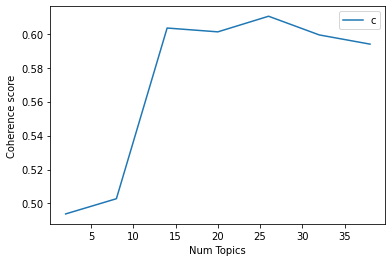

In [39]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4938
Num Topics = 8  has Coherence Value of 0.5028
Num Topics = 14  has Coherence Value of 0.6034
Num Topics = 20  has Coherence Value of 0.6011
Num Topics = 26  has Coherence Value of 0.6103
Num Topics = 32  has Coherence Value of 0.5993
Num Topics = 38  has Coherence Value of 0.5939


In [41]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.012*"article" + 0.011*"write" + 0.011*"problem" + 0.010*"science" + '
  '0.010*"effect" + 0.009*"make" + 0.009*"line" + 0.009*"food" + 0.008*"day" + '
  '0.008*"good"'),
 (1,
  '0.030*"drive" + 0.024*"card" + 0.019*"problem" + 0.019*"system" + '
  '0.015*"driver" + 0.013*"bit" + 0.013*"run" + 0.013*"disk" + 0.012*"work" + '
  '0.011*"computer"'),
 (2,
  '0.031*"game" + 0.025*"team" + 0.022*"play" + 0.020*"year" + 0.016*"player" '
  '+ 0.014*"win" + 0.014*"good" + 0.010*"season" + 0.009*"fan" + '
  '0.009*"hockey"'),
 (3,
  '0.012*"drug" + 0.012*"year" + 0.009*"people" + 0.009*"child" + '
  '0.009*"study" + 0.009*"group" + 0.008*"number" + 0.008*"report" + '
  '0.008*"man" + 0.008*"show"'),
 (4,
  '0.017*"christian" + 0.014*"people" + 0.011*"religion" + 0.010*"life" + '
  '0.009*"word" + 0.009*"love" + 0.009*"faith" + 0.009*"church" + 0.008*"man" '
  '+ 0.008*"atheist"'),
 (5,
  '0.168*"line" + 0.120*"nntp_poste" + 0.107*"organization" + 0.107*"host" + '
  '0.037*"university" 

In [81]:
print(optimal_model[corpus][0])

[(0, 0.043827160493827164), (1, 0.037654320987654324), (2, 0.03888888888888889), (3, 0.04135802469135803), (4, 0.047530864197530866), (5, 0.09444444444444444), (6, 0.033950617283950615), (7, 0.04506172839506173), (8, 0.03641975308641975), (9, 0.03518518518518519), (10, 0.027777777777777776), (11, 0.04876543209876543), (12, 0.043827160493827164), (13, 0.1808641975308642), (14, 0.033950617283950615), (15, 0.040123456790123455), (16, 0.037654320987654324), (17, 0.05123456790123457), (18, 0.046296296296296294), (19, 0.03518518518518519)]


In [82]:
!wget https://github.com/statianas/mallet-2.0.8/blob/main/mallet-2.0.8.rar

--2022-12-07 22:02:52--  https://github.com/statianas/mallet-2.0.8/blob/main/mallet-2.0.8.rar
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘mallet-2.0.8.rar’

mallet-2.0.8.rar        [  <=>               ] 139.80K   267KB/s    in 0.5s    

2022-12-07 22:02:54 (267 KB/s) - ‘mallet-2.0.8.rar’ saved [143153]



In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print("OLD", row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        print("NEW", row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [58]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
#display(sent_topics_outdf_grpd)
#display(df_topic_sents_keywords)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

display(sent_topics_sorteddf_mallet) #слева кажется было показано то, сколько 
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
display(sent_topics_sorteddf_mallet)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
display(sent_topics_sorteddf_mallet)
# Show
sent_topics_sorteddf_mallet.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
1400,0.0,0.6609,"article, write, problem, science, effect, make...",From: Subject: How To Prevent Kidney Stone For...
7499,1.0,0.7961,"drive, card, problem, system, driver, bit, run...",From: (D. Keith Rice) Subject: Re: Drive/Contr...
8642,2.0,0.7879,"game, team, play, year, player, win, good, sea...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
11156,3.0,0.7842,"drug, year, people, child, study, group, numbe...",From: (David Dodell) Subject: HICN610 Medical ...
8493,4.0,0.6274,"christian, people, religion, life, word, love,...",From: (Robert Weiss) Subject: [lds] Ricks repl...
6076,5.0,0.2905,"line, nntp_poste, organization, host, universi...",From: (Tony Alicea) Subject: Re: Rosicrucian O...
2339,6.0,0.7224,"power, line, work, ground, box, current, high,...","From: Subject: Grounding power wiring, was Re:..."
491,7.0,0.6835,"question, make, exist, claim, true, people, re...",From: mathew Subject: Alt.Atheism FAQ: Constru...
5612,8.0,0.8853,"key, system, encryption, bit, technology, chip...",From: (Clipper Chip Announcement) Subject: tex...
8519,9.0,0.7449,"time, good, book, problem, find, point, line, ...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."


,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0.0,0.6609,"article, write, problem, science, effect, make...",From: Subject: How To Prevent Kidney Stone For...
1,1.0,0.7961,"drive, card, problem, system, driver, bit, run...",From: (D. Keith Rice) Subject: Re: Drive/Contr...
2,2.0,0.7879,"game, team, play, year, player, win, good, sea...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
3,3.0,0.7842,"drug, year, people, child, study, group, numbe...",From: (David Dodell) Subject: HICN610 Medical ...
4,4.0,0.6274,"christian, people, religion, life, word, love,...",From: (Robert Weiss) Subject: [lds] Ricks repl...
5,5.0,0.2905,"line, nntp_poste, organization, host, universi...",From: (Tony Alicea) Subject: Re: Rosicrucian O...
6,6.0,0.7224,"power, line, work, ground, box, current, high,...","From: Subject: Grounding power wiring, was Re:..."
7,7.0,0.6835,"question, make, exist, claim, true, people, re...",From: mathew Subject: Alt.Atheism FAQ: Constru...
8,8.0,0.8853,"key, system, encryption, bit, technology, chip...",From: (Clipper Chip Announcement) Subject: tex...
9,9.0,0.7449,"time, good, book, problem, find, point, line, ...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6609,"article, write, problem, science, effect, make...",From: Subject: How To Prevent Kidney Stone For...
1,1.0,0.7961,"drive, card, problem, system, driver, bit, run...",From: (D. Keith Rice) Subject: Re: Drive/Contr...
2,2.0,0.7879,"game, team, play, year, player, win, good, sea...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
3,3.0,0.7842,"drug, year, people, child, study, group, numbe...",From: (David Dodell) Subject: HICN610 Medical ...
4,4.0,0.6274,"christian, people, religion, life, word, love,...",From: (Robert Weiss) Subject: [lds] Ricks repl...
5,5.0,0.2905,"line, nntp_poste, organization, host, universi...",From: (Tony Alicea) Subject: Re: Rosicrucian O...
6,6.0,0.7224,"power, line, work, ground, box, current, high,...","From: Subject: Grounding power wiring, was Re:..."
7,7.0,0.6835,"question, make, exist, claim, true, people, re...",From: mathew Subject: Alt.Atheism FAQ: Constru...
8,8.0,0.8853,"key, system, encryption, bit, technology, chip...",From: (Clipper Chip Announcement) Subject: tex...
9,9.0,0.7449,"time, good, book, problem, find, point, line, ...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6609,"article, write, problem, science, effect, make...",From: Subject: How To Prevent Kidney Stone For...
1,1.0,0.7961,"drive, card, problem, system, driver, bit, run...",From: (D. Keith Rice) Subject: Re: Drive/Contr...
2,2.0,0.7879,"game, team, play, year, player, win, good, sea...",From: (bryan.k.strouse) Subject: NHL RESULTS F...
3,3.0,0.7842,"drug, year, people, child, study, group, numbe...",From: (David Dodell) Subject: HICN610 Medical ...
4,4.0,0.6274,"christian, people, religion, life, word, love,...",From: (Robert Weiss) Subject: [lds] Ricks repl...


In [78]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
#display(topic_counts)
topic_counts = topic_counts.sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
#print(topic_contribution)

# Topic Number and Keywords
#1topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

0.0     0.0376
1.0     0.1190
2.0     0.0921
3.0     0.0297
4.0     0.0643
5.0     0.0836
6.0     0.0525
7.0     0.0331
8.0     0.0458
9.0     0.0194
10.0    0.0009
11.0    0.0319
12.0    0.0361
13.0    0.0911
14.0    0.0752
15.0    0.0439
16.0    0.0542
17.0    0.0192
18.0    0.0409
19.0    0.0297
Name: Dominant_Topic, dtype: float64


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"article, write, problem, science, effect, make...",425,0.0376
1.0,1.0,"drive, card, problem, system, driver, bit, run...",1346,0.1190
2.0,2.0,"game, team, play, year, player, win, good, sea...",1042,0.0921
3.0,3.0,"drug, year, people, child, study, group, numbe...",336,0.0297
4.0,4.0,"christian, people, religion, life, word, love,...",727,0.0643
5.0,5.0,"line, nntp_poste, organization, host, universi...",946,0.0836
6.0,6.0,"power, line, work, ground, box, current, high,...",594,0.0525
7.0,7.0,"question, make, exist, claim, true, people, re...",374,0.0331
8.0,8.0,"key, system, encryption, bit, technology, chip...",518,0.0458
9.0,9.0,"time, good, book, problem, find, point, line, ...",219,0.0194


In [ ]:
display(df_dominant_topics.dropna())